<img src="./images/logo.png" alt="Drawing" style="width: 500px;"/>

# **Exercise 4:** Building an Image Classification Model with Tensorflow and MLflow

You presented your Superset Dashboard to your retail company executives. They like the numbers and are raving about the insights you have gathered and visually presented in such an clean, intuitive manner.

You're about to conclude when suddenly, someone sidetracks the conversation. Since the introduction of self-serve checkouts to your retail stores, your customers have had to manually search up fresh produce items through a clunky UI. "What a pain!" every executive cries. They've all experienced this during their own shopping.

"What about all of those self-serve checkouts that have cameras above the scanners?" someone asks. "Could we use them to **automatically detect** what produce a customer has just placed on the scale and deliver a wonderful, futurisitc user experience?". They turn to you. You've now been tasked with building that very feature into all the self-serve checkouts across your company's stores.

Seeing as video cameras are just a stream of static pictures, you realize that the first thing you will need to do is create a model to **detect produce in images**.  

In this exercise, you will do just that, through learning how to:

- Load and preprocess your image datasets.
- Prepare a model for training on your dataset.
- Learn about parameters and neural network layers.
- Train a model using Tensorflow.
- Store the modela and its training metrics in MLflow.
- Test the model and validate its accuracy.

By the end of this exercise, you will have trained your own **classification model** using Tensorflow and MLflow to detect and classify produce (*"That's a carrot!"*) in any given image!

Let's dive in!

### **Prerequisites**

As instructed in the [Introductory notebook](./00.introduction.ipynb), ensure that you have run `pip install -r requirements.txt` in a Terminal window, located in the same working directory, prior to running this notebook. 

## **1. Importing Libraries**

Let's import some of the libraries we will use to train a model, most of which are common to most machine learning workflows:

**NumPy (np)**:
   - **Purpose**: NumPy is a fundamental package for scientific computing in Python. It provides support for arrays, matrices, and mathematical functions, making it essential for numerical operations.
   - **Usage**: NumPy arrays are used extensively for data manipulation and mathematical operations. It offers efficient data structures for handling large datasets, which is crucial for training machine learning models.


**Pandas (pd)**:
   - **Purpose**: Pandas is a powerful data manipulation and analysis library. It provides easy-to-use data structures and data manipulation tools, making it ideal for data preprocessing and cleaning.
   - **Usage**: Pandas DataFrames are used for handling structured data. It facilitates tasks such as data loading, cleaning, filtering, and transformation, which are essential steps in preparing data for model training.


**TensorFlow (tf)**:
   - **Purpose**: TensorFlow is an open-source machine learning framework developed by Google. It provides comprehensive tools and libraries for building and deploying machine learning models, including neural networks.
   - **Usage**: TensorFlow offers a high-level API for building and training deep learning models efficiently. It supports both high-level and low-level operations, allowing for flexibility in model design and optimization. It also provides tools for model deployment and serving, making it suitable for both research and production use cases.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import mlflow
import mlflow.tensorflow  
from mlflow.tracking.client import MlflowClient
from mlflow.models import signature
import os
import urllib3
import time
import requests
import json
from IPython.display import display
from PIL import Image
from io import BytesIO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-03-07 10:13:39.118532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 10:13:39.122707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 10:13:39.135229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741342419.155387    1380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741342419.161395    1380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 10:13:39.183005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Ignore any warnings that appear above.

In [2]:
%update_token

Token successfully refreshed.


## **2. Loading and Preparing the Image Dataset**

Now, let's load the three image datasets that have been supplied to you by your data engineering team. Wait, why more than one?

In general, any single dataset you wish to build, train and fine-tune models on should be split up into three datasets (containing percentage of dataset): **training** (80%), **testing** (10%) and **validation** (10%). The **validation** dataset will be used to validate the accuracy of the model **during** training, whilst the **testing** dataset will be used validate the accuracy of the model **after** it has been trained. 

We're first going to declare the paths of where these datasets currently live. Run the following command to get the full working path of this exercise:

In [3]:
%pwd

'/mnt/user/vince/ezua-tutorials/demos/smart-retail'

Copy the output (without the surrounding apostrophes) into the root_path variable below.

In [14]:
root_path = '/mnt/user/vince/ezua-tutorials/demos/smart-retail' #Insert the output of the %pwd command here


#For faster training times (<5 minutes) rather than the whole dataset. 
#Do not change. Full dataset download link coming soon.
quick_training = True

#Declare dataset path
if quick_training:
    path = root_path + '/datasets/quick/'
else:
    path = root_path + '/datasets/full/'
    
print(path)

/mnt/user/vince/ezua-tutorials/demos/smart-retail/datasets/quick/


We'll now create lists of all the image paths in each of the datasets.

In [15]:
# Create a Path object for the training directory and get a list of all .jpg files in the directory
train_dir = Path(path + 'train')
train_filepaths = [p for p in train_dir.glob('**/*') if p.suffix.lower() in ['.jpg', '.jpeg'] and not p.name.startswith('.')]

# Create a Path object for the testing directory and get a list of all .jpg files in the directory
test_dir = Path(path + 'test')
test_filepaths = [p for p in test_dir.glob('**/*') if p.suffix.lower() in ['.jpg', '.jpeg'] and not p.name.startswith('.')]

# Create a Path object for the validation directory and get a list of all .jpg files in the directory
val_dir = Path(path + 'validation')
val_filepaths = [p for p in val_dir.glob('**/*') if p.suffix.lower() in ['.jpg', '.jpeg'] and not p.name.startswith('.')]

Next, we'll define a function that takes in all of the images from a given dataset and determines the **labels** for each of the images. It will then return and a shuffled list of images (rather than sorted alphabetically or by date, to ensure that we are training the model on unordered images) and their labels as a Pandas DataFrame. 

In [16]:
# Define a function to create a DataFrame with filepaths and labels for image data
def proc_img(filepath):
    """
    This function takes a list of image file paths as input and creates a DataFrame containing:
    - The original file paths
    - Extracted labels from the file path structure
    - Shuffled rows for random presentation
    """

    # 1. Filter out unwanted subfolders:
    # Exclude Jupyter's checkpoint folders to avoid processing unnecessary files
    filepath = [x for x in filepath if ".ipynb_checkpoints" not in str(x)]

    # 2. Extract labels from file paths:
    # Derive labels from the second-to-last segment of each file path, typically indicating categories
    labels = [
        str(filepath[i]).split("/")[-2]
        for i in range(len(filepath))
        if not str(filepath[i]).split("/")[-2].startswith(".")  # Exclude hidden files/folders
    ]

    # 3. Create pandas Series for filepaths and labels:
    # Organize filepaths and labels into structured Series for DataFrame creation
    filepath = pd.Series(filepath, name="Filepath", dtype=str)
    labels = pd.Series(labels, name="Label", dtype=str)

    # 4. Construct the DataFrame:
    # Combine filepaths and labels into a single DataFrame for convenient analysis
    df = pd.concat([filepath, labels], axis=1)

    # 5. Shuffle and reset index:
    # Randomize the order of rows for unbiased processing and training
    # Reset the index to start from 0 for consistency
    df = df.sample(frac=1).reset_index(drop=True)

    return df

We'll create those shuffled lists for the training, testing and validation datasets.

In [17]:
# Call the proc_img function on the training filepaths to create a DataFrame for training
train_df = proc_img(train_filepaths)
train_df.dropna(inplace=True)

# Call the proc_img function on the testing filepaths to create a DataFrame for testing
test_df = proc_img(test_filepaths)
test_df.dropna(inplace=True)

# Call the proc_img function on the validation filepaths to create a DataFrame for validation
val_df = proc_img(val_filepaths)
val_df.dropna(inplace=True)

if {len(train_df.Label.unique())} != {len(test_df.Label.unique())} != {len(val_df.Label.unique())}:
    print('incorrect amount of Labels, please do not continue...')

And here's how the datasets look!

In [18]:
print()
print('#### Training set ####')
print()
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')
print()
print('#### Test set ####')
print()
print('-- Test set --\n')
print(f'Number of pictures: {test_df.shape[0]}\n')
print(f'Number of different labels: {len(test_df.Label.unique())}\n')
print(f'Labels: {test_df.Label.unique()}')
print()
print('#### Validation set ####')
print()
print('-- Validate set --\n')
print(f'Number of pictures: {val_df.shape[0]}\n')
print(f'Number of different labels: {len(val_df.Label.unique())}\n')
print(f'Labels: {val_df.Label.unique()}')



#### Training set ####

-- Training set --

Number of pictures: 818

Number of different labels: 6

Labels: ['banana' 'orange' 'apple' 'lemon' 'carrot' 'cucumber']

#### Test set ####

-- Test set --

Number of pictures: 56

Number of different labels: 6

Labels: ['apple' 'cucumber' 'banana' 'lemon' 'orange' 'carrot']

#### Validation set ####

-- Validate set --

Number of pictures: 56

Number of different labels: 6

Labels: ['lemon' 'orange' 'carrot' 'apple' 'cucumber' 'banana']


In [19]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,/mnt/user/vince/ezua-tutorials/demos/smart-ret...,banana
1,/mnt/user/vince/ezua-tutorials/demos/smart-ret...,orange
2,/mnt/user/vince/ezua-tutorials/demos/smart-ret...,orange
3,/mnt/user/vince/ezua-tutorials/demos/smart-ret...,banana
4,/mnt/user/vince/ezua-tutorials/demos/smart-ret...,apple


Let's see what some of the training dataset looks like. We'll pull out a set of images (one per category) from the dataset with labels.

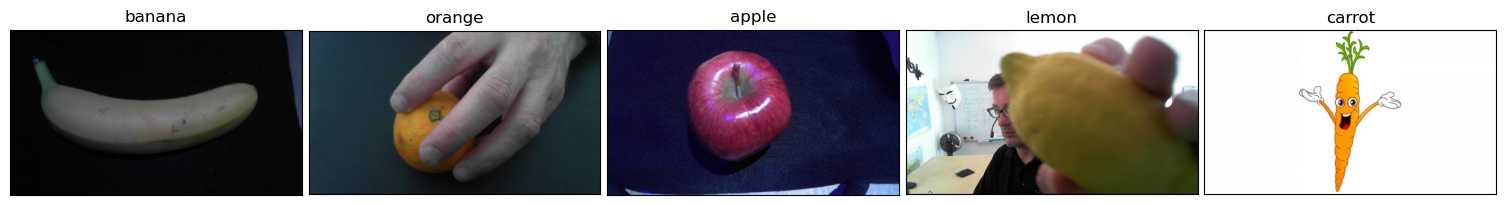

In [20]:
# 1. Select a diverse set of images for visualization:
# Create a DataFrame that includes only one image from each category to showcase variety
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# 2. Prepare a visually appealing display:
# Create a figure with 5 subplots arranged horizontally to display multiple images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 10),
                            subplot_kw={'xticks': [], 'yticks': []})  # Hide unnecessary axes

# 3. Iterate through selected images and visualize them:
for i, ax in enumerate(axes.flat):  # Flatten the axes for easier iteration
    if i < len(df_unique):  # Ensure we don't exceed available images
        # Load and display the image
        ax.imshow(plt.imread(df_unique.iloc[i]['Filepath']))
        # Add a clear label for context
        ax.set_title(df_unique.iloc[i]['Label'], fontsize=12)

# 4. Refine layout for better viewing:
plt.tight_layout(pad=0.5)  # Adjust spacing for visual clarity

# 5. Display the plot:
plt.show()


And with that, our data is ready for it's preperation for model training. 

## **3. Preparing the Model**

To detect produce as it is scanned at the checkout, we are going to train a **MobileNetV2** object recognition model. MobileNetV2 is a lightweight convolutional neural network (CNN) architecture designed for smaller devices, such as mobile and embedded devices. MobileNetV2 excels at image classification tasks like identifying objects in pictures while requiring minimal computing power and memory, making it perfect for applications such as this!

To train a MobileNetV2 model, we'll first declare the **image data generators** specifically written for MobileNetV2 for each of the training, testing and validation datasets. The `ImageDataGenerator` class efficiently prepares and delivers batches of images during training. It utilizes a custom preprocessing function (`tf.keras.applications.mobilenet_v2.preprocess_input`) that prepares each image to MobileNetV2's requirements, typically including scaling pixel values and subtracting specific means from each color channel. This streamlined approach ensures images are formatted correctly for optimal performance within the MobileNetV2 architecture.

##### **Click to expand for a further deep dive into each of the parameters used to configure the data generators below.**

A few things our data generators will perform on our dataset include:
- Utilizes tf.keras.preprocessing.image.ImageDataGenerator for real-time data augmentation during training.
- The training images are loaded from a Pandas DataFrame using the specified 'Filepath' column for input data and 'Label' column for output data.
- Images are resized to (224, 224) pixels, and the MobileNetV2 preprocessing function is applied.
- Data augmentation techniques like rotation, zoom, shift, shear, and horizontal flip are employed to enhance the diversity of the training dataset.
- Batches of 32 images are generated, and the order is shuffled for each epoch.

They will be defined by the following parameters:

1. **flow_from_dataframe:** This is a method provided by the `ImageDataGenerator` class in TensorFlow Keras. It specifically creates a data generator that reads data from a Pandas DataFrame. 

2. **dataframe (train_df):** This refers to the Pandas DataFrame you provide. It's expected to contain two columns:
   - **x_col ('Filepath')**: This column should contain the file paths of the images you want to train on.
   - **y_col ('Label')**: This column should hold the corresponding labels for each image, likely representing the category it belongs to (e.g., "cat", "dog", "car").

3. **target_size=(224, 224):** This specifies the desired size for the resized images. In this case, all images will be resized to 224 pixels wide and 224 pixels tall. Resizing images ensures consistency and reduces computational complexity during training.

4. **color_mode='rgb':** This indicates that the images are assumed to be in RGB color mode, which uses three channels (red, green, blue) to represent color information.

5. **class_mode='categorical':** This signifies that the task is categorical classification. The model will learn to classify images into predefined categories based on the labels provided.

6. **batch_size=32:** This defines the number of images that will be processed together as a single batch during training.  A batch size of 32 means the model will receive 32 images and their labels at a time to update its internal parameters.

7. **shuffle=True:** This setting enables shuffling of the image order within each batch. Shuffling helps prevent the model from overfitting to the training data by ensuring it sees images in a random order during each training epoch (iteration).

8. **seed=0:**  This sets a seed value for the random number generator used for shuffling and data augmentation.  Using a fixed seed ensures that the data order and augmentations are reproducible, meaning you'll get the same results when re-running the code. 

9. **Data Augmentation:** These are the following techniques applied to randomly modify the training images:
    - **rotation_range=30:** Images are randomly rotated up to 30 degrees in either direction.
    - **zoom_range=0.15:** Images are randomly zoomed in or out by up to 15%.
    - **width_shift_range=0.2, height_shift_range=0.2:** Images are randomly shifted horizontally or vertically by up to 20% of their width or height, respectively.
    - **shear_range=0.15:** A shearing transformation is applied to distort the image slightly.
    - **horizontal_flip=True:** Images are randomly flipped horizontally (mirrored).

10. **fill_mode="nearest":** This setting determines how empty spaces created by image transformations (e.g., zooming) are filled. Here, the "nearest" neighbor pixel filling is used, meaning the value of the closest pixel is copied to fill the empty space.


####

First, let's leverage the pre-configured scripts from the Tensorflow library to declare an instance of MobileNetV2 model (stored in the repo for your convenience).

In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3), 
    include_top=False, 
    weights=None,
    pooling='avg')
    
pretrained_model.load_weights('resources/mobilenet_v2.h5')
    
pretrained_model.trainable = False

2025-03-07 10:16:40.209459: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Next, we'll set up the data generator for **training** dataset, applying the appropriate transforms. **Confirm** that the numbers match what we know from above about these datasets.

In [22]:
# Create an image data generator for preprocessing train images using MobileNetV2
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [23]:
# Generate a flow of images and labels from a Pandas dataframe for training
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # Use the specified Pandas dataframe
    x_col='Filepath', # Use the 'Filepath' column as the input (x) data
    y_col='Label', # Use the 'Label' column as the output (y) data
    target_size=(224, 224), # Resize the images to the specified dimensions
    color_mode='rgb', # Use RGB color mode
    class_mode='categorical', # Use categorical classification
    batch_size=32, # Generate batches of 32 images at a time
    shuffle=True, # Shuffle the order of the images
    seed=0, # Use a fixed seed for reproducibility
    rotation_range=30, # Randomly rotate images up to 30 degrees
    zoom_range=0.15, # Randomly zoom images up to 15%
    width_shift_range=0.2, # Randomly shift images horizontally up to 20%
    height_shift_range=0.2, # Randomly shift images vertically up to 20%
    shear_range=0.15, # Randomly apply shearing transformations to images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode="nearest", # Use the nearest pixel to fill any empty spaces created by image transformations
)

Found 818 validated image filenames belonging to 6 classes.


Then, the **testing** dataset. 

In [24]:
# Create an image data generator for preprocessing test images using MobileNetV2
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [25]:

# Generate a flow of images and labels from a Pandas dataframe
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, # Use the specified Pandas dataframe
    x_col='Filepath', # Use the 'Filepath' column as the input (x) data
    y_col='Label', # Use the 'Label' column as the output (y) data
    target_size=(224, 224), # Resize the images to the specified dimensions
    color_mode='rgb', # Use RGB color mode
    class_mode='categorical', # Use categorical classification
    batch_size=32, # Generate batches of 32 images at a time
    shuffle=False # Do not shuffle the order of the images
)

Found 56 validated image filenames belonging to 6 classes.


And finally, the **validation** dataset. 

In [26]:
# Create an image data generator for preprocessing validation images using MobileNetV2
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [27]:

# Generate a flow of images and labels from a Pandas dataframe for validation
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df, # Use the specified Pandas dataframe
    x_col='Filepath', # Use the 'Filepath' column as the input (x) data
    y_col='Label', # Use the 'Label' column as the output (y) data
    target_size=(224, 224), # Resize the images to the specified dimensions
    color_mode='rgb', # Use RGB color mode
    class_mode='categorical', # Use categorical classification
    batch_size=32, # Generate batches of 32 images at a time
    shuffle=True, # Shuffle the order of the images
    seed=0, # Use a fixed seed for reproducibility
    rotation_range=30, # Randomly rotate images up to 30 degrees
    zoom_range=0.15, # Randomly zoom images up to 15%
    width_shift_range=0.2, # Randomly shift images horizontally up to 20%
    height_shift_range=0.2, # Randomly shift images vertically up to 20%
    shear_range=0.15, # Randomly apply shearing transformations to images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode="nearest" # Use the nearest pixel to fill any empty spaces created by image transformations
)

Found 56 validated image filenames belonging to 6 classes.


## **4. Preparing for Training**

Now that we've prepared our datasets and created an instance of the base model that we will train, our last step is to declare important machine learning parameters to our training run. 

### A Brief Introduction to Training Parameters

The ways in which machines learn concepts from new information is not dissimilar to the way humans do. Like humans, the method by which a machine learns is to be repeatedly exposed to data that reinforces that concept. Additionally, for any given person and any given concept, there is a better or best method to learn that concept (and of course, there are certainly suboptimal ways to learn that concept also!). In machine learning, these methods are defined by a set of **parameters** that will define how and when a model will be exposed to new data, such that it can best extrapolate patterns from it. 

Three important parameters that we will introduce to you to facilitate this training run are **epochs**, **batch sizes** and **patience**. 


Imagine you're studying for a history exam using the course textbook made up of 10 chapters.

#### **Epochs:** 

A single epoch is going through all 10 chapters **once**. Each time you re-read the textbook, you change your understanding of the content changes - some concepts are strengthened, some negated, others changed entirely. The number of **epochs** is the total amount of times you read the whole textbook through all 15 chapters. Read the textbook too few times and you will not be able to identify answers in the final quiz (known as **underfitting**). Read the book too many times, however, and you may memorize the content so well that any question that you will struggle with any question that does not strictly adhere to what you read in the book (known as **overfitting**). 

For our model, instead of a textbook of 10 chapters, we have a **training** dataset of hundreds of images. Setting the epoch parameter to **15** will result in the training run iterating over the entire dataset of images **15 times**.

#### **Batch Size:**  

A batch size is how many chapters you can read in a single sitting. If you want to speed read to get the whole book read in 30 minutes, you probably haven't properly absorbed any of the content. To properly engage with the content, you read a chapter or even sections of chapters at a time in **batches**. Too few chapters at a time will be slow, and you'll likely forget how concepts in chapters correlated to one another, affecting your learning. Read too fast and you'll miss key historic details.

For our training run, we will process **32 images at a time**. 

#### **Patience:** 

To validate your understanding, after each textbook readthrough, you quiz yourself on questions that are relevant but were **not** in the example questions of the textbook. If by the fourth time you've read through the textbook, your are unable to answer the new questions correctly (that is to say, you cannot **abstract** your understanding to questions or content beyond what was in the textbook), you will stop studying and go talk with your professor - clearly there is something you're not getting, and there might be a better way to learn it. Do this too early and your professor will tell you that you didn't spend enough time learning the content to properly grasp it. Do this too late and you waste valuable study time trying to grasp a concept with an incorrect methodolgy. 

For our training run, we will use random images from the **validation** dataset to validate our model's learning as it continues to pass through each epoch. If after 4 epochs, the objects the models detect in the random test images are not what is labelled, then the training run will halt. In these instances, usually the dataset or the model parameters will need to be tweaked.  

To summarize this training run: The model will run through the **training** dataset **15** times, **32 photos at a time**. Using the **validation** dataset, we will validate the model's detection accuracy every runthrough of the dataset - and halt the training run if the accuracy is not adequate after **4** consecutive runs.

Let's define those parameters for our run now.

In [28]:
# Define the number of epochs to train the model
param_epoch = 2

# Define the batch size to use for training and validation
param_batch_size = 32

# Define the number of epochs to wait before early stopping if the validation loss does not improve
param_patience = 2

### What's in a layer?

In neural networks, a **layer** is a group of interconnected processing units (known as nodes or neurons) that processes and transforms input data to produce an output. By combining multiple layers in a neural network, complex relationships and patterns within the data can be learned and utilized for various machine learning tasks - such as being able to recognise pixel patterns that make up specific objects, like fruits or vegetables! 

To describe the types of layers, let's consider an example related to our produce recognition model. Each produce item will have different colors, shapes, and sizes that make it uniquely identifyable. Each layer is a friend helping you determine what any given piece of produce is. How will they all work together? In layers!

1. **Input Layer**: You start by showing your friend the fruits and vegetables, one by one. They take a good look and notice all the details - like whether they're round, long, green, or yellow.

2. **Hidden Layers**: Your friend has a few friends of their own. They pass the items along to them, along with the information they observed about that particlar produce item, to those friends - each of whom will each focuses on different features. One friend might pay attention to the color, another to the shape, and so on. They all talk to each other and combine their observations to present the information to one more person...

3. **Output Layer**: Finally, after all this analyzing, your best friend recieves all this analysis and makes a final guess. They say, "I think this is an apple," or "This looks like a carrot." This is the output - the conclusion your best friend reached after all the thinking and analyzing between your other friends.

So, each layer in the neural network helps to break down the information about the input image of a fruit or vegetable, step by step, until it can make a statistically probable guess about what is present in the image. The neural network we are building to do this is known as a **classification model**. 

We will now adds some new layers to the MobileNetV2 model we declared earlier to make the model better at recognizing patterns in the data. After that, we will figure out how many different categories our dataset has based on the labels. We'll then set up the final layer of the neural network to give an answer for each category. Finally, we'll set up the rules for training the model, like how it should learn and how it should measure its accuracy.

In [29]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Get the input layer of the pre-trained model
inputs = pretrained_model.input

# Add new layers to improve the pre-trained model for our specific task
# First new layer with 128 units and ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
# Second new layer with 128 units and ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Figure out how many categories (labels) our data has
labels = len(train_df.Label.unique())

# Add the final layer to give answers for each category
# This layer has softmax activation to output probabilities for each category
outputs = tf.keras.layers.Dense(labels, activation='softmax')(x)

# Create the neural network model with input and output layers
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with training rules
# Using Adam optimizer, categorical cross-entropy loss, and accuracy as the metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Lastly, we'll confirm the identified labels for our training are correct.

In [30]:
labels = (train_images.class_indices)
print(labels)

{'apple': 0, 'banana': 1, 'carrot': 2, 'cucumber': 3, 'lemon': 4, 'orange': 5}


## **5. It's time to train!**

Now that we have prepared our data and our model, it is time to begin a **training experiment**. We *could* just run a notebook cell or a single Python script, but doing so would result in limitations when it comes to managing and scaling our experiments, especially as the complexity of our models and datasets grow as our retail stores gather more data and model feedback. Enter MLflow.

### Introducing MLFlow

MLflow is an open-source machine learning platform that is designed to help data scientists and engineers simplify the intricacies inherent in machine learning endeavors, rendering their projects more manageable, collaborative traceable, and reproducible.

Before the world was introduced to MLflow, engineers managed machine learning tasks using a mix of tools and methods, which lacked consistency and efficiency. They manually explored data, developed models with libraries like scikit-learn or TensorFlow, and tracked experiments in spreadsheets. Model management relied on conventional version control like Git, while deployment and monitoring required custom scripts. Collaboration and reproducibility suffered due to ad-hoc sharing (such as sharing large model files over networks) and difficulties in replicating experiments across environments (often due to confliciting libraries or dependencies).

Today, MLflow is the most utilized and contributed machine learning platform and comes natively installed with **HPE Ezmeral Unified Analytics**.

Over the course of the remainder of this exercise and the next, we will learn to leverage the key features of MLflow to build our produce recognition model, including:

1. **Experiment Tracking**: MLflow enables users to meticulously track experiment details such as parameters and metrics. This functionality facilitates the comparison of different runs and aids in analyzing results, empowering data scientists to discern which models yield superior performance and allowing for fine-tuning of their approaches.

2. **Model Management**: The platform provides tools for packaging and storing trained models in a reusable format. This ensures that models can be effortlessly applied to new data or shared with collaborators.

3. **Model Registry**: MLflow offers a Model Registry, allowing for centralized management of models and their various versions. This feature proves invaluable in production environments where model governance and monitoring are paramount.

4. **Project Management**: MLflow facilitates the packaging of entire machine learning projects, encompassing code and environment settings, thereby streamlining sharing and reproducibility.

### Creating an MLflow Experiment

To start, let's create an MLflow **experiment**, which is a container for running individual executions of a **machine learning training script** (below) with specific **parameters** (above!). Having an Experiment will help organize and manage different iterations of our model's training, allowing for easy comparison, reproducibility, and progress tracking in machine learning projects.

In [31]:
%update_token

Token successfully refreshed.


Let's give both our **experiment** and our **model** a name and declare the path in the artifacts associated with this Experiment as to where our model is to be saved.

In [32]:
# Experiment variables for MLflow
experiment_name = "retail-experiment"
model_name = "produce-detection"
artifact_path = "model"

We'll confirm that no experiments with the same name currently exist. If not, we'll create that experiment in MLflow.

In [33]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Search for existing experiments 
experiments = mlflow.search_experiments(view_type=3, order_by=["experiment_id"], filter_string="name = '" + experiment_name + "'")

# Check if the existing experiments list is not empty before accessing its elements
if experiments and experiments[0].lifecycle_stage == 'deleted':
    MlflowClient().restore_experiment(experiments[0].experiment_id)

# Create MLflow experiment and generate MLflow run name
mlflow.set_experiment(experiment_name)

# Define time-stamped name for this specific run.
run_name = model_name + time.strftime("%Y%m%d-%H%M%S", time.localtime())

2025/03/07 10:17:00 INFO mlflow.tracking.fluent: Experiment with name 'retail-experiment' does not exist. Creating a new experiment.


And with that, we've connected to the native MLflow instance running on Unified Analytics and created an experiment - no setup of or connection to MLflow from this notebook required. This is the power of running applications such as MLflow on **HPE Ezmeral Unified Analytics**!

### Beginning the training run

Our training begins with the `model.fit()` function in the middle of the code block. Before that, we'll **log** the **parameters** we declared earlier, such that we know what they were for this run and we can **compare** them with the **accuracy** of the model. Tweaking these parameters between runs on the same dataset is known as **tuning** a model.

The training of the model will then run on the specified hyperparameters and incorporate an early stopping callback to prevent overfitting (determined by our **patience** parameter). Once training is complete, the trained model is saved as an **MLflow artifact**, along with metrics such as training and validation accuracy. Notably, the model is saved with a specific version, such that we can choose what **version** we want to test new data on or even **serve** to a production application. Throughout the run, the **validation** dataset is employed to evaluate the model's performance on unseen data, aiding in preventing overfitting and ensuring the model's generalizability.

Let's begin our training run! 

In [44]:
import mlflow.tensorflow
import bentoml
import tensorflow as tf

# Example parameters and data setup
param_epoch = 1
param_batch_size = 32
param_patience = 5
run_name = "my_run"
artifact_path = "model"

# Assume train_images, val_images, and your Keras model are defined elsewhere
# model = ...

# End any active MLflow run
if mlflow.active_run():
    mlflow.end_run()

# Start a new MLflow run
with mlflow.start_run(run_name=run_name):

    # Enable autologging for model architecture and metrics
    mlflow.autolog()  
    
    # Log hyperparameters
    mlflow.log_param("batch_size", param_batch_size)
    mlflow.log_param("epochs", param_epoch)
    mlflow.log_param("patience", param_patience)
    
    # Train the model with early stopping
    history = model.fit(
        train_images,
        validation_data=val_images,
        batch_size=param_batch_size,
        epochs=param_epoch,
        verbose='auto',
        callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=param_patience,
                restore_best_weights=True
            )]
    )
    
    # Log training metrics for each epoch
    for metric, values in history.history.items():
        for value in values:
            mlflow.log_metric(metric, value)
    
    # Save the model in BentoML format
    bento_model = bentoml.tensorflow.save_model("retail-detection", model)
    print(f"Bento model saved at: {bento_model.path}")

    # Optionally, log the BentoML model folder as an MLflow artifact.
    # This will upload the entire directory to the MLflow run's artifacts.
    mlflow.log_artifacts(bento_model.path, artifact_path="bentoml_model")

2025/03/07 11:20:49 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.5.0, but the installed version is 3.9.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2025/03/07 11:20:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/07 11:20:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/07 11:20:49 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
2025/03/07 11:20:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/03/07 11:20:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 7.2398e-04

You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 1.0000 - loss: 7.2675e-04 - val_accuracy: 0.9464 - val_loss: 0.1907


2025/03/07 11:21:36 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/03/07 11:21:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/03/07 11:21:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Using the default model signature for Tensorflow ({'predict_function': {'batchable': False}}) for model "retail-detection".
Assets written to: /tmp/tmp3mukwxphbentoml_model_retail-detection/assets
HTTP Request: POST https://t.bentoml.com "HTTP/1.1 200 OK"


Bento model saved at: /home/admin/bentoml/models/retail-detection/lymiqhx3i2u3swvm/


2025/03/07 11:21:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run my_run at: http://mlflow.mlflow.svc.cluster.local:5000/#/experiments/14/runs/c14de2f8a7a84d1e83d204c3f324dd4f.
2025/03/07 11:21:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.mlflow.svc.cluster.local:5000/#/experiments/14.


And with that, we have our own produce **classification model**!

But the question begs... how good is it?

## **6. Model Testing**

This code segment predicts the labels of test images using a pre-trained model. It first predicts the probabilities for each class using the model's `predict` function and then selects the class with the highest probability for each image. Next, it maps the numeric labels to their corresponding class names using a dictionary created from the training data's class indices. This step converts the numeric predictions into human-readable class names. The true labels for the test images are also mapped to class names. Then, the code calculates the accuracy of the model's predictions on the test set using the `accuracy_score` function from scikit-learn, comparing the predicted labels with the true labels, and prints the accuracy percentage.

In [35]:
# Predict labels for the test images using the trained model
pred = model.predict(test_images)
# Convert predicted probabilities into class labels by selecting the class with the highest probability for each image
pred = np.argmax(pred, axis=1)

# Map numeric labels to their corresponding class names
labels = train_images.class_indices
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Map true labels of test images to their corresponding class names
y_test = [labels[k] for k in test_images.classes]

# Compute accuracy of the model's predictions on the test set
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)

# Print the accuracy percentage
print(f'Accuracy on the test set: {100*acc:.2f}%')


/home/admin/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Accuracy on the test set: 89.29%


For a **first run**, that is pretty good! We will use this model for the remainder of our exercises. 

### Validating with your own image!

We'll set up a little `predict` function which will take any image we give it, prepare the image for the way the model likes it, then parse it to the model for it to predict what, if any, produce is in the image.

In [36]:
def predict(location):
    
    #Check to see if a web URL or a local file is being parsed 
    if "http" in location:
        response = requests.get(location)
        img = Image.open(BytesIO(response.content))
    else:
        from tensorflow.keras.preprocessing.image import load_img,img_to_array
        img=load_img(location,target_size=(224,224,3))
    
    #Convert the image into the dimensions of the model's input layer.
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    
    # Infer the model with the image
    answer=model.predict(img)

    # Format the answer
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    
    return res

Now, **go out** onto Google Images and find any image with a **orange**, an **apple** or a **lemon**. Copy the link into the `online_url` variable.

If you are in an offline/proxy environment, upload your file to the same directory as this notebook and call it **test_image.jpg**. An has been supplied if you just wish to run the cell without finding your own image.

In [37]:
# Load the path for our image, be it a web URL or a local file
online_url = ""
local_url = os.getcwd() + "/images/test_image.jpg"

if online_url:
    image_url = online_url
else:
    image_url = local_url

#Infer our model with the image to make a prediction
predicted_label = predict(image_url)
print("The model predicts: " + str(predicted_label))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
The model predicts: orange


Did the model correctly guess what was in your image? If so, great! If not... also great!

**Incorrect predictions** from models provide vital feedback that can help you to understand the model's behaviour and improve either the training dataset or the model.

# **Conclusion**

In a single exercise, you have learned the basics of machine learning - including how to import and prepare a dataset, define training parameters, trained a model using Tensorflow and set up an MLflow experiment to monitor the training run.

Now, we have a model file that we can run `model.precict` on any new image to detect any fresh produce our retail customers are scanning at the checkout! 

In the next exercise, we will run through MLflow in more detail. Training and fine tuning models is an interative process, so ensuring that our models are appropriately registered and training experiments are tracked not only provides us with new, identifyable base models for which to train new data on, but when our model is deployed to hundreds of retail stores across several countries, we can be sure we're using the right one! 

This will put you in good sted for the final two exercises, where you will learn to manage several versions of the model you just created and **serve** it to our in-store retail application!